# Growing Neural Cellular Automata

This notebook contains code to reproduce experiments and figures for the ["Growing Neural Cellular Automata"](http://distill.pub/2020/growing-ca) article.

Copyright 2020 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [1]:
#@title Imports and Notebook Utilities
# %tensorflow_version 2.x

import os
import io
import PIL.Image, PIL.ImageDraw
import base64
import zipfile
import json
import requests
import numpy as np
import matplotlib.pylab as pl
import glob

import tensorflow as tf

from IPython.display import Image, HTML, clear_output
import tqdm

import os
os.environ['FFMPEG_BINARY'] = '/opt/homebrew/Cellar/ffmpeg/7.1.1_4/bin/ffmpeg'  # Adjust this path as needed

import moviepy.editor as mvp    # pip install moviepy==1.0.3
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter
clear_output()

def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def im2url(a, fmt='jpeg'):
  encoded = imencode(a, fmt)
  base64_byte_string = base64.b64encode(encoded).decode('ascii')
  return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string

def imshow(a, fmt='jpeg'):
  display(Image(data=imencode(a, fmt)))

def tile2d(a, w=None):
  a = np.asarray(a)
  if w is None:
    w = int(np.ceil(np.sqrt(len(a))))
  th, tw = a.shape[1:3]
  pad = (w-len(a))%w
  a = np.pad(a, [(0, pad)]+[(0, 0)]*(a.ndim-1), 'constant')
  h = len(a)//w
  a = a.reshape([h, w]+list(a.shape[1:]))
  a = np.rollaxis(a, 2, 1).reshape([th*h, tw*w]+list(a.shape[4:]))
  return a

def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img

class VideoWriter:
  def __init__(self, filename, fps=30.0, **kw):
    self.writer = None
    self.params = dict(filename=filename, fps=fps, **kw)

  def add(self, img):
    img = np.asarray(img)
    if self.writer is None:
      h, w = img.shape[:2]
      self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
    if img.dtype in [np.float32, np.float64]:
      img = np.uint8(img.clip(0, 1)*255)
    if len(img.shape) == 2:
      img = np.repeat(img[..., None], 3, -1)
    self.writer.write_frame(img)

  def close(self):
    if self.writer:
      self.writer.close()

  def __enter__(self):
    return self

  def __exit__(self, *kw):
    self.close()

In [6]:
#@title Cellular Automata Parameters
CHANNEL_N = 16        # Number of CA state channels
TARGET_PADDING = 16   # Number of pixels used to pad the target image border
TARGET_SIZE = 40
BATCH_SIZE = 8
POOL_SIZE = 1024
CELL_FIRE_RATE = 0.5

TARGET_EMOJI = "🦎" #@param {type:"string"}

EXPERIMENT_TYPE = "Regenerating" #@param ["Growing", "Persistent", "Regenerating"]
EXPERIMENT_MAP = {"Growing":0, "Persistent":1, "Regenerating":2}
EXPERIMENT_N = EXPERIMENT_MAP[EXPERIMENT_TYPE]

USE_PATTERN_POOL = [0, 1, 1][EXPERIMENT_N]
DAMAGE_N = [0, 0, 3][EXPERIMENT_N]  # Number of patterns to damage in a batch

In [7]:
#@title CA Model and Utilities
from tensorflow.keras.layers import Conv2D

def load_image(url, max_size=TARGET_SIZE):
  r = requests.get(url)
  img = PIL.Image.open(io.BytesIO(r.content))
  img.thumbnail((max_size, max_size), PIL.Image.LANCZOS)
  img = np.float32(img)/255.0
  # premultiply RGB by Alpha
  img[..., :3] *= img[..., 3:]
  return img

def load_emoji(emoji):
  code = hex(ord(emoji))[2:].lower()
  url = 'https://github.com/googlefonts/noto-emoji/blob/main/png/128/emoji_u%s.png?raw=true'%code
  return load_image(url)


def to_rgba(x):
  return x[..., :4]

def to_alpha(x):
  return tf.clip_by_value(x[..., 3:4], 0.0, 1.0)

def to_rgb(x):
  # assume rgb premultiplied by alpha
  rgb, a = x[..., :3], to_alpha(x)
  return 1.0-a+rgb

def get_living_mask(x):
  alpha = x[:, :, :, 3:4]
  return tf.nn.max_pool2d(alpha, 3, [1, 1, 1, 1], 'SAME') > 0.1

def make_seed(size, n=1):
  x = np.zeros([n, size, size, CHANNEL_N], np.float32)
  x[:, size//2, size//2, 3:] = 1.0
  return x


class CAModel(tf.keras.Model):

  def __init__(self, channel_n=CHANNEL_N, fire_rate=CELL_FIRE_RATE):
    super().__init__()
    self.channel_n = channel_n
    self.fire_rate = fire_rate

    self.dmodel = tf.keras.Sequential([
          Conv2D(128, 1, activation=tf.nn.relu),
          Conv2D(self.channel_n, 1, activation=None,
              kernel_initializer=tf.zeros_initializer),
    ])

    self(tf.zeros([1, 3, 3, channel_n]))  # dummy call to build the model

  @tf.function
  def perceive(self, x, angle=0.0):
    identify = np.float32([0, 1, 0])
    identify = np.outer(identify, identify)
    dx = np.outer([1, 2, 1], [-1, 0, 1]) / 8.0  # Sobel filter
    dy = dx.T
    c, s = tf.cos(angle), tf.sin(angle)
    kernel = tf.stack([identify, c*dx-s*dy, s*dx+c*dy], -1)[:, :, None, :]
    kernel = tf.repeat(kernel, self.channel_n, 2)
    y = tf.nn.depthwise_conv2d(x, kernel, [1, 1, 1, 1], 'SAME')
    return y

  @tf.function
  def call(self, x, fire_rate=None, angle=0.0, step_size=1.0):
    pre_life_mask = get_living_mask(x)

    y = self.perceive(x, angle)
    dx = self.dmodel(y)*step_size
    if fire_rate is None:
      fire_rate = self.fire_rate
    update_mask = tf.random.uniform(tf.shape(x[:, :, :, :1])) <= fire_rate
    x += dx * tf.cast(update_mask, tf.float32)

    post_life_mask = get_living_mask(x)
    life_mask = pre_life_mask & post_life_mask
    return x * tf.cast(life_mask, tf.float32)


CAModel().dmodel.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (1, 3, 3, 128)         │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (1, 3, 3, 16)          │         2,064 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,336 (32.56 KB)

 Trainable params: 8,336 (32.56 KB)

 Non-trainable params: 0 (0.00 B)

# Training

In [8]:
#@title Train Utilities (SamplePool, Model Export, Damage)
from google.protobuf.json_format import MessageToDict
from tensorflow.python.framework import convert_to_constants

class SamplePool:
  def __init__(self, *, _parent=None, _parent_idx=None, **slots):
    self._parent = _parent
    self._parent_idx = _parent_idx
    self._slot_names = slots.keys()
    self._size = None
    for k, v in slots.items():
      if self._size is None:
        self._size = len(v)
      assert self._size == len(v)
      setattr(self, k, np.asarray(v))

  def sample(self, n):
    idx = np.random.choice(self._size, n, False)
    batch = {k: getattr(self, k)[idx] for k in self._slot_names}
    batch = SamplePool(**batch, _parent=self, _parent_idx=idx)
    return batch

  def commit(self):
    for k in self._slot_names:
      getattr(self._parent, k)[self._parent_idx] = getattr(self, k)

@tf.function
def make_circle_masks(n, h, w):
  x = tf.linspace(-1.0, 1.0, w)[None, None, :]
  y = tf.linspace(-1.0, 1.0, h)[None, :, None]
  center = tf.random.uniform([2, n, 1, 1], -0.5, 0.5)
  r = tf.random.uniform([n, 1, 1], 0.1, 0.4)
  x, y = (x-center[0])/r, (y-center[1])/r
  mask = tf.cast(x*x+y*y < 1.0, tf.float32)
  return mask

def export_model(ca, base_fn):
  ca.save_weights(base_fn)

  cf = ca.call.get_concrete_function(
      x=tf.TensorSpec([None, None, None, CHANNEL_N]),
      fire_rate=tf.constant(0.5),
      angle=tf.constant(0.0),
      step_size=tf.constant(1.0))
  cf = convert_to_constants.convert_variables_to_constants_v2(cf)
  graph_def = cf.graph.as_graph_def()
  graph_json = MessageToDict(graph_def)
  graph_json['versions'] = dict(producer='1.14', minConsumer='1.14')
  model_json = {
      'format': 'graph-model',
      'modelTopology': graph_json,
      'weightsManifest': [],
  }
  with open(base_fn+'.json', 'w') as f:
    json.dump(model_json, f)

def generate_pool_figures(pool, step_i):
  tiled_pool = tile2d(to_rgb(pool.x[:49]))
  fade = np.linspace(1.0, 0.0, 72)
  ones = np.ones(72)
  tiled_pool[:, :72] += (-tiled_pool[:, :72] + ones[None, :, None]) * fade[None, :, None]
  tiled_pool[:, -72:] += (-tiled_pool[:, -72:] + ones[None, :, None]) * fade[None, ::-1, None]
  tiled_pool[:72, :] += (-tiled_pool[:72, :] + ones[:, None, None]) * fade[:, None, None]
  tiled_pool[-72:, :] += (-tiled_pool[-72:, :] + ones[:, None, None]) * fade[::-1, None, None]
  imwrite('train_log/%04d_pool.jpg'%step_i, tiled_pool)

def visualize_batch(x0, x, step_i):
  vis0 = np.hstack(to_rgb(x0).numpy())
  vis1 = np.hstack(to_rgb(x).numpy())
  vis = np.vstack([vis0, vis1])
  imwrite('train_log/batches_%04d.jpg'%step_i, vis)
  print('batch (before/after):')
  imshow(vis)

def plot_loss(loss_log):
  pl.figure(figsize=(10, 4))
  pl.title('Loss history (log10)')
  pl.plot(np.log10(loss_log), '.', alpha=0.1)
  pl.show()


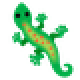

In [9]:
#@title Choose Target Image { vertical-output: true}
#url = 'https://github.com/google-research/self-organising-systems/blob/master/assets/growing_ca/planaria2_48.png?raw=true'
#target_img = load_image(url, 48)

target_img = load_emoji(TARGET_EMOJI)
imshow(zoom(to_rgb(target_img), 2), fmt='png')

In [10]:
#@title Initialize Training { vertical-output: true}

p = TARGET_PADDING
pad_target = tf.pad(target_img, [(p, p), (p, p), (0, 0)])
h, w = pad_target.shape[:2]
seed = np.zeros([h, w, CHANNEL_N], np.float32)
seed[h//2, w//2, 3:] = 1.0

def loss_f(x):
  return tf.reduce_mean(tf.square(to_rgba(x)-pad_target), [-2, -3, -1])

ca = CAModel()

loss_log = []

lr = 2e-3
lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    [2000], [lr, lr*0.1])
trainer = tf.keras.optimizers.Adam(lr_sched)

loss0 = loss_f(seed).numpy()
pool = SamplePool(x=np.repeat(seed[None, ...], POOL_SIZE, 0))

!mkdir -p train_log && rm -f train_log/*

batch (before/after):


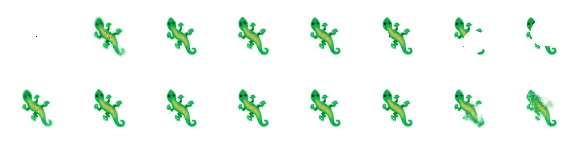

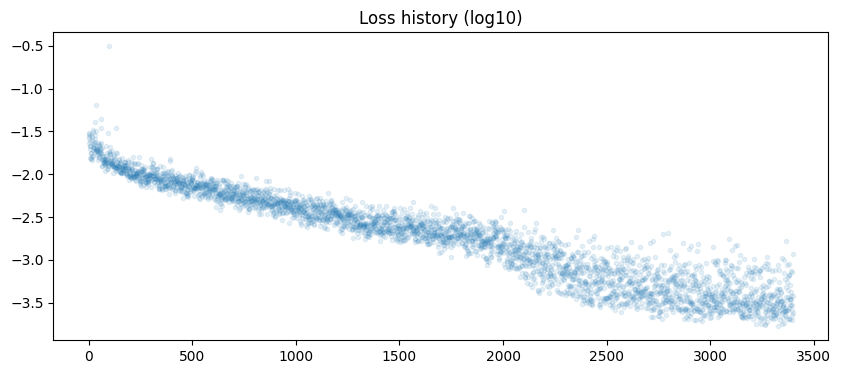

 step: 3401, log10(loss): -2.926

I0000 00:00:1756210871.870293 1137399 devices.cc:76] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
I0000 00:00:1756210871.870356 1137399 single_machine.cc:376] Starting new session


 step: 3489, log10(loss): -3.593

KeyboardInterrupt: 

In [11]:
#@title Training Loop {vertical-output: true}

@tf.function
def train_step(x):
  iter_n = tf.random.uniform([], 64, 96, tf.int32)
  with tf.GradientTape() as g:
    for i in tf.range(iter_n):
      x = ca(x)
    loss = tf.reduce_mean(loss_f(x))
  grads = g.gradient(loss, ca.weights)
  grads = [g/(tf.norm(g)+1e-8) for g in grads]
  trainer.apply_gradients(zip(grads, ca.weights))
  return x, loss

for i in range(8000+1):
  if USE_PATTERN_POOL:
    batch = pool.sample(BATCH_SIZE)
    x0 = batch.x
    loss_rank = loss_f(x0).numpy().argsort()[::-1]
    x0 = x0[loss_rank]
    x0[:1] = seed
    if DAMAGE_N:
      damage = 1.0-make_circle_masks(DAMAGE_N, h, w).numpy()[..., None]
      x0[-DAMAGE_N:] *= damage
  else:
    x0 = np.repeat(seed[None, ...], BATCH_SIZE, 0)

  x, loss = train_step(x0)

  if USE_PATTERN_POOL:
    batch.x[:] = x
    batch.commit()

  step_i = len(loss_log)
  loss_log.append(loss.numpy())

  if step_i%10 == 0:
    generate_pool_figures(pool, step_i)
  if step_i%100 == 0:
    clear_output()
    visualize_batch(x0, x, step_i)
    plot_loss(loss_log)
    export_model(ca, 'train_log/%04d.weights.h5'%step_i)

  print('\r step: %d, log10(loss): %.3f'%(len(loss_log), np.log10(loss)), end='')

In [ ]:
loss_log_serializable = [float(v) for v in loss_log]

with open("train_log/final_loss_log.json", "w") as f:
  json.dump(loss_log_serializable, f)

# Figures

In [13]:
#@title Training Progress (Checkpoints)

models = []
for i in [100, 500, 1000, 4000]:
  ca = CAModel()
  ca.load_weights('train_log/%04d.weights.h5'%i)
  models.append(ca)

out_fn = 'train_steps_damage_%d.mp4'%DAMAGE_N
x = np.zeros([len(models), 72, 72, CHANNEL_N], np.float32)
x[..., 36, 36, 3:] = 1.0
with VideoWriter(out_fn) as vid:
  for i in tqdm.trange(500):
    vis = np.hstack(to_rgb(x))
    vid.add(zoom(vis, 2))
    for ca, xk in zip(models, x):
      xk[:] = ca(xk[None,...])[0]
mvp.ipython_display(out_fn)

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:04<00:00, 104.79it/s]


In [14]:
#@title Training Progress (Batches)
frames = sorted(glob.glob('train_log/batches_*.jpg'))
mvp.ImageSequenceClip(frames, fps=10.0).write_videofile('batches.mp4')
mvp.ipython_display('batches.mp4')

Moviepy - Building video batches.mp4.
Moviepy - Writing video batches.mp4



Moviepy - Done !
Moviepy - video ready batches.mp4


In [15]:
#@title Pool Contents
frames = sorted(glob.glob('train_log/*_pool.jpg'))[:80]
mvp.ImageSequenceClip(frames, fps=20.0).write_videofile('pool.mp4')
mvp.ipython_display('pool.mp4')

Moviepy - Building video pool.mp4.
Moviepy - Writing video pool.mp4



Moviepy - Done !
Moviepy - video ready pool.mp4


## Pretrained Models and Figures

Please run the cell below to download pretrained models that are used to generate the subsequent figures. The figures generated after this are generated using the pretrained CAs.

In [26]:
# !wget -O models.zip 'https://github.com/google-research/self-organising-systems/blob/master/assets/growing_ca/models.zip?raw=true'
# !unzip -oq models.zip

EMOJI = '🦎😀💥👁🐠🦋🐞🕸🥨🎄'

def get_model(emoji='🦋', fire_rate=0.5, use_pool=1, damage_n=3, run=0,
              prefix='models/', output='model'):
  path = prefix
  assert fire_rate in [0.5, 1.0]
  if fire_rate==0.5:
    path += 'use_sample_pool_%d damage_n_%d '%(use_pool, damage_n)
  elif fire_rate==1.0:
    path += 'fire_rate_1.0 '
  code = hex(ord(emoji))[2:].upper()
  path += 'target_emoji_%s run_index_%d/08000'%(code, run)
  assert output in ['model', 'json']
  if output == 'model':
    ca = CAModel(channel_n=16, fire_rate=fire_rate)
    ca.load_weights(path)
    return ca
  elif output == 'json':
    return open(path+'.json', 'r').read()

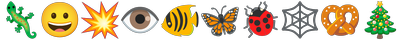

In [18]:
atlas = np.hstack([load_emoji(e) for e in EMOJI])
imshow(atlas)

In [27]:
#@title Teaser
models = [get_model(emoji, run=1) for emoji in EMOJI]

with VideoWriter('teaser.mp4') as vid:
  x = np.zeros([len(EMOJI), 64, 64, CHANNEL_N], np.float32)
  # grow
  for i in tqdm.trange(200):
    k = i//20
    if i%20==0 and k<len(EMOJI):
      x[k, 32, 32, 3:] = 1.0
    vid.add(zoom(tile2d(to_rgb(x), 5), 2))
    for ca, xk in zip(models, x):
      xk[:] = ca(xk[None,...])[0]
  # damage
  mask = PIL.Image.new('L', (64*5, 64*2))
  draw = PIL.ImageDraw.Draw(mask)
  for i in tqdm.trange(400):
    cx, r = i*3-20, 6
    y1, y2 = 32+np.sin(i/5+np.pi)*8, 32+64+np.sin(i/5)*8
    draw.rectangle((0, 0, 64*5, 64*2), fill=0)
    draw.ellipse((cx-r, y1-r, cx+r, y1+r), fill=255)
    draw.ellipse((cx-r, y2-r, cx+r, y2+r), fill=255)
    x *= 1.0-(np.float32(mask).reshape(2, 64, 5, 64)
        .transpose([0, 2, 1, 3]).reshape(10, 64, 64, 1))/255.0
    if i<200 or i%2 == 0:
      vid.add(zoom(tile2d(to_rgb(x), 5), 2))
    for ca, xk in zip(models, x):
      xk[:] = ca(xk[None,...])[0]
  # fade out
  last = zoom(tile2d(to_rgb(x), 5), 2)
  for t in np.linspace(0, 1, 30):
    vid.add(last*(1.0-t)+t)

mvp.ipython_display('teaser.mp4', loop=True)

ValueError: File format not supported: filepath=models/use_sample_pool_1 damage_n_3 target_emoji_1F98E run_index_1/08000. Keras 3 only supports V3 `.keras` and `.weights.h5` files, or legacy V1/V2 `.h5` files.

In [ ]:
#@title Unstable Patterns
!wget -O slider.png 'https://github.com/google-research/self-organising-systems/raw/master/assets/growing_ca/slider.png?raw=true'

import PIL.ImageFont
from matplotlib import font_manager as fm
font_fn = fm.findfont(fm.FontProperties())
font = PIL.ImageFont.truetype(font_fn, 20)

models = [get_model(ch, use_pool=0, damage_n=0) for ch in EMOJI]
fn = 'unstable.mp4'
with VideoWriter(fn) as vid:
  x = np.zeros([len(EMOJI), 64, 64, CHANNEL_N], np.float32)
  x[:, 32, 32, 3:] = 1.0
  # grow
  slider = PIL.Image.open("slider.png")
  for i in tqdm.trange(1000):
    if i<200 or i%5 == 0:
      vis = zoom(tile2d(to_rgb(x), 5), 4).clip(0, 1)
      vis_extended = np.concatenate((vis, np.ones((164, vis.shape[1], 3))), axis=0)
      im = np.uint8(vis_extended*255)
      im = PIL.Image.fromarray(im)
      im.paste(slider, box=(20, vis.shape[0]+20))
      draw = PIL.ImageDraw.Draw(im)
      p_x = (14 + (610/1000)*i)*2.0
      draw.rectangle([p_x, vis.shape[0]+20+55, p_x+10, vis.shape[0]+20+82], fill="#434343bd")
      vid.add(np.uint8(im))
    for ca, xk in zip(models, x):
      xk[:] = ca(xk[None,...])[0]
  # fade out
  for t in np.linspace(0, 1, 30):
    vid.add(vis_extended*(1.0-t)+t)

mvp.ipython_display(fn, loop=True)

In [ ]:
#@title Rotation
row_size = 4
models_of_interest = ["🦋","🦎","🐠","😀"]
num_images = 16
imgs = []
start_angle = np.random.randint(13, 76)

for i in np.arange(num_images):
  ang = start_angle + i * np.random.randint(36, 111)
  ang = ang/360.0 * 2 * np.pi
  if i % row_size == 0:
    ca = get_model(models_of_interest[i // row_size])
  x = np.zeros([1, 56, 56, CHANNEL_N], np.float32)
  x[:, 28, 28, 3:] = 1.0
  for i in range(500):
    ang = tf.constant(ang, tf.float32)
    x = ca(x, angle=ang)
  imgs.append(to_rgb(x)[0])
# Assumes the result is a multiple of row_size
assert len(imgs) % row_size == 0
imgs = zip(*(iter(imgs),) * row_size)

imgs_arr = np.concatenate([np.hstack(im_row) for im_row in imgs])
vis = zoom(imgs_arr, 4)

imshow(vis, fmt='png')

In [ ]:
#@title Regeneration (trained without damage)
models = [get_model(ch, damage_n=0) for ch in '😀🦋🦎']
with VideoWriter('regen1.mp4') as vid:
  x = np.zeros([len(models), 5, 56, 56, CHANNEL_N], np.float32)
  cx, cy = 28, 28
  x[:, :, cy, cx, 3:] = 1.0
  for i in tqdm.trange(2000):
    if i == 200:
      x[:, 0, cy:] = x[:, 1, :cy] = 0
      x[:, 2, :, cx:] = x[:, 3, :, :cx] = 0
      x[:, 4, cy-8:cy+8, cx-8:cx+8] = 0
    vis = to_rgb(x)
    vis = np.vstack([np.hstack(row) for row in vis])
    vis = zoom(vis, 2)
    if (i < 400 and i%2==0) or i%8 == 0:
      vid.add(vis)
    if i == 200:
      for _ in range(29):
        vid.add(vis)
    for ca, row in zip(models, x):
      row[:] = ca(row)

mvp.ipython_display('regen1.mp4')

In [ ]:
#@title Regeneration (trained with damage)
models = [get_model(ch, damage_n=3) for ch in '😀🦋🦎']
with VideoWriter('regen2.mp4') as vid:
  x = np.zeros([len(models), 5, 56, 56, CHANNEL_N], np.float32)
  cx, cy = 28, 28
  x[:, :, cy, cx, 3:] = 1.0
  for i in tqdm.trange(2000):
    if i == 200:
      x[:, 0, cy:] = x[:, 1, :cy] = 0
      x[:, 2, :, cx:] = x[:, 3, :, :cx] = 0
      x[:, 4, cy-8:cy+8, cx-8:cx+8] = 0
    vis = to_rgb(x)
    vis = np.vstack([np.hstack(row) for row in vis])
    vis = zoom(vis, 2)
    if (i < 400 and i%2==0) or i%8 == 0:
      vid.add(vis)
    if i == 200:
      for _ in range(29):
        vid.add(vis)
    for ca, row in zip(models, x):
      row[:] = ca(row)

mvp.ipython_display('regen2.mp4')

In [ ]:
#@title Planarian
!wget -O planarian.zip 'https://github.com/google-research/self-organising-systems/blob/master/assets/growing_ca/planarian.zip?raw=true'
!unzip -oq planarian.zip -d planarian

ca = CAModel()
ca.load_weights('planarian/train_log/8000')

x = np.zeros([1, 64, 96, CHANNEL_N], np.float32)
x[:, 32, 48, 3:] = 1.0
with VideoWriter('planarian.mp4', 30.0) as vid:
  for i in range(400):
    vid.add(zoom(to_rgb(x[0])))
    x = ca(x, angle=np.pi/2.0)
    if i==150:
      x = x.numpy()
      for k in range(24):
        x[:,:24] = np.roll(x[:,:24], 1, 2)
        x[:,-24:] = np.roll(x[:,-24:], -1, 2)
        vid.add(zoom(to_rgb(x[0])))
      for k in range(20):
        vid.add(zoom(to_rgb(x[0])))

mvp.ipython_display('planarian.mp4')

# Interactive Demos


In [ ]:
#@title TensorFlow.js Demo {run:"auto", vertical-output: true}
#@markdown Select "CHECKPOINT" model to load the checkpoint created by running cells from the "Training" section of this notebook
import IPython.display

model = "CHECKPOINT"  #@param ['CHECKPOINT', '😀 1F600', '💥 1F4A5', '👁 1F441', '🦎 1F98E', '🐠 1F420', '🦋 1F98B', '🐞 1F41E', '🕸 1F578', '🥨 1F968', '🎄 1F384']
model_type = '3 regenerating'  #@param ['1 naive', '2 persistent', '3 regenerating']

#@markdown Shift-click to seed the pattern

if model != 'CHECKPOINT':
  code = model.split(' ')[1]
  emoji = chr(int(code, 16))
  experiment_i = int(model_type.split()[0])-1
  use_pool = (0, 1, 1)[experiment_i]
  damage_n = (0, 0, 3)[experiment_i]
  model_str = get_model(emoji, use_pool=use_pool, damage_n=damage_n, output='json')
else:
  last_checkpoint_fn = sorted(glob.glob('train_log/*.json'))[-1]
  model_str = open(last_checkpoint_fn).read()

data_js = '''
  window.GRAPH_URL = URL.createObjectURL(new Blob([`%s`], {type: 'application/json'}));
'''%(model_str)

display(IPython.display.Javascript(data_js))


IPython.display.HTML('''
<script src="https://cdn.jsdelivr.net/npm/@tensorflow/tfjs@2.3.0/dist/tf.min.js"></script>

<canvas id='canvas' style="border: 1px solid black; image-rendering: pixelated;"></canvas>

<script>
  "use strict";

  const sleep = (ms)=>new Promise(resolve => setTimeout(resolve, ms));

  const parseConsts = model_graph=>{
    const dtypes = {'DT_INT32':['int32', 'intVal', Int32Array],
                    'DT_FLOAT':['float32', 'floatVal', Float32Array]};

    const consts = {};
    model_graph.modelTopology.node.filter(n=>n.op=='Const').forEach((node=>{
      const v = node.attr.value.tensor;
      const [dtype, field, arrayType] = dtypes[v.dtype];
      if (!v.tensorShape.dim) {
        consts[node.name] = [tf.scalar(v[field][0], dtype)];
      } else {
        // if there is a 0-length dimension, the exported graph json lacks "size"
        const shape = v.tensorShape.dim.map(d=>(!d.size) ? 0 : parseInt(d.size));
        let arr;
        if (v.tensorContent) {
          const data = atob(v.tensorContent);
          const buf = new Uint8Array(data.length);
          for (var i=0; i<data.length; ++i) {
            buf[i] = data.charCodeAt(i);
          }
          arr = new arrayType(buf.buffer);
        } else {
          const size = shape.reduce((a, b)=>a*b);
          arr = new arrayType(size);
          if (size) {
            arr.fill(v[field][0]);
          }
        }
        consts[node.name] = [tf.tensor(arr, shape, dtype)];
      }
    }));
    return consts;
  }

  const run = async ()=>{
    const r = await fetch(GRAPH_URL);
    const consts = parseConsts(await r.json());

    const model = await tf.loadGraphModel(GRAPH_URL);
    Object.assign(model.weights, consts);

    let seed = new Array(16).fill(0).map((x, i)=>i<3?0:1);
    seed = tf.tensor(seed, [1, 1, 1, 16]);

    const D = 96;
    const initState = tf.tidy(()=>{
      const D2 = D/2;
      const a = seed.pad([[0, 0], [D2-1, D2], [D2-1, D2], [0,0]]);
      return a;
    });

    const state = tf.variable(initState);
    const [_, h, w, ch] = state.shape;

    const damage = (x, y, r)=>{
      tf.tidy(()=>{
        const rx = tf.range(0, w).sub(x).div(r).square().expandDims(0);
        const ry = tf.range(0, h).sub(y).div(r).square().expandDims(1);
        const mask = rx.add(ry).greater(1.0).expandDims(2);
        state.assign(state.mul(mask));
      });
    }

    const plantSeed = (x, y)=>{
      const x2 = w-x-seed.shape[2];
      const y2 = h-y-seed.shape[1];
      if (x<0 || x2<0 || y2<0 || y2<0)
        return;
      tf.tidy(()=>{
        const a = seed.pad([[0, 0], [y, y2], [x, x2], [0,0]]);
        state.assign(state.add(a));
      });
    }

    const scale = 4;

    const canvas = document.getElementById('canvas');
    const ctx = canvas.getContext('2d');
    canvas.width = w;
    canvas.height = h;
    canvas.style.width = `${w*scale}px`;
    canvas.style.height = `${h*scale}px`;

    canvas.onmousedown = e=>{
      const x = Math.floor(e.clientX/scale);
        const y = Math.floor(e.clientY/scale);
        if (e.buttons == 1) {
          if (e.shiftKey) {
            plantSeed(x, y);
          } else {
            damage(x, y, 8);
          }
        }
    }
    canvas.onmousemove = e=>{
      const x = Math.floor(e.clientX/scale);
      const y = Math.floor(e.clientY/scale);
      if (e.buttons == 1 && !e.shiftKey) {
        damage(x, y, 8);
      }
    }

    function step() {
      tf.tidy(()=>{
        state.assign(model.execute(
            {x:state, fire_rate:tf.tensor(0.5),
            angle:tf.tensor(0.0), step_size:tf.tensor(1.0)}, ['Identity']));
      });
    }

    function render() {
      step();

      const imageData = tf.tidy(()=>{
        const rgba = state.slice([0, 0, 0, 0], [-1, -1, -1, 4]);
        const a = state.slice([0, 0, 0, 3], [-1, -1, -1, 1]);
        const img = tf.tensor(1.0).sub(a).add(rgba).mul(255);
        const rgbaBytes = new Uint8ClampedArray(img.dataSync());
        return new ImageData(rgbaBytes, w, h);
      });
      ctx.putImageData(imageData, 0, 0);

      requestAnimationFrame(render);
    }
    render();
  }
  run();

</script>
''')

In [ ]:
#@title WebGL Demo

#@markdown This code exports quantized models for the WebGL demo that is used in the article.
#@markdown The demo code can be found at https://github.com/distillpub/post--growing-ca/blob/master/public/ca.js

def pack_layer(weight, bias, outputType=np.uint8):
  in_ch, out_ch = weight.shape
  assert (in_ch%4==0) and (out_ch%4==0) and (bias.shape==(out_ch,))
  weight_scale, bias_scale = 1.0, 1.0
  if outputType == np.uint8:
    weight_scale = 2.0*np.abs(weight).max()
    bias_scale = 2.0*np.abs(bias).max()
    weight = np.round((weight/weight_scale+0.5)*255)
    bias = np.round((bias/bias_scale+0.5)*255)
  packed = np.vstack([weight, bias[None,...]])
  packed = packed.reshape(in_ch+1, out_ch//4, 4)
  packed = outputType(packed)
  packed_b64 = base64.b64encode(packed.tobytes()).decode('ascii')
  return {'data_b64': packed_b64, 'in_ch': in_ch, 'out_ch': out_ch,
          'weight_scale': weight_scale, 'bias_scale': bias_scale,
          'type': outputType.__name__}

def export_ca_to_webgl_demo(ca, outputType=np.uint8):
  # reorder the first layer inputs to meet webgl demo perception layout
  chn = ca.channel_n
  w1 = ca.weights[0][0, 0].numpy()
  w1 = w1.reshape(chn, 3, -1).transpose(1, 0, 2).reshape(3*chn, -1)
  layers = [
      pack_layer(w1, ca.weights[1].numpy(), outputType),
      pack_layer(ca.weights[2][0, 0].numpy(), ca.weights[3].numpy(), outputType)
  ]
  return json.dumps(layers)

with zipfile.ZipFile('webgl_models8.zip', 'w') as zf:
  for e in EMOJI:
    zf.writestr('ex1_%s.json'%e, export_ca_to_webgl_demo(get_model(e, use_pool=0, damage_n=0)))
    run = 1 if e in '😀🕸' else 0  # select runs that happen to quantize better
    zf.writestr('ex2_%s.json'%e, export_ca_to_webgl_demo(get_model(e, use_pool=1, damage_n=0, run=run)))
    run = 1 if e in '🦎' else 0    # select runs that happen to quantize better
    zf.writestr('ex3_%s.json'%e, export_ca_to_webgl_demo(get_model(e, use_pool=1, damage_n=3, run=run)))